# Project Fatigue
- GitHub [link](https://github.com/romainmartinez/fatigue)

## todos
- keras/tensorflow: [link](https://medium.com/@williamkoehrsen/deep-neural-network-classifier-32c12ff46b6c)
- model optimization
- viz xgboost
- add sex in pipeline
- report html
- feature importance

In [ ]:
# Common imports
import scipy.io as sio
import numpy as np
import os

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 0. load data

In [35]:
DATA_PATH = os.path.join('.', 'data/')
DATA_FILE = 'DatabaseRPT.mat'
mat = sio.loadmat(os.path.join(DATA_PATH, DATA_FILE))['DataBaseRPT'][0, 0]

- label
    - `Y` (1, 162): 1 = prefatigue, 2 = fatigue

- used features
    - `AllX` (24, 162): 24 (6 DoF x 4 variables) x 162 (81 participants x 2 time points).
    - `CAssignAll` (1, 24): AllX column assignment

    - `Sex` (1, 162)
    - `Endurance` (1, 162)

- not used
    - `BestX` (7, 162): 7 (variables with SRM>0.8) x 162 (81 participants x 2 time points) matrix. Contains data only for the most responsive variables (SRM>0.8).
    - `CAssignBest` (1, 7): BestX column assignment.
    - `Age` (1, 162): too much NaN.
    - `Height` (1, 162): too much NaN.
    - `Weight` (1, 162) Too much NaN.
    - `SubjectKey` (1, 162): useless.
    - `SID` (1, 162): useless.

### create feature matrix

In [36]:
col_names = [i[0] for i in mat['CAssignAll'].flatten()]
# find variable with SRM > .8
srm_names = np.array([i[0] for i in mat['CAssignBest'].flatten()])
srm_idx = np.in1d(col_names, srm_names)

# add `AllX`
X = mat['AllX'].T

# add `Sex`
X = np.c_[X, mat['Sex'].T]
col_names.append('Sex')

col_names = np.array(col_names)

### create label vector

In [37]:
from sklearn.preprocessing import LabelBinarizer
y = mat['Y'].T
y = LabelBinarizer().fit_transform(y)

### create report

In [38]:
import os.path
import pandas as pd

# create dataframe
df = pd.DataFrame(X, columns=col_names)
df['fatigue (label)'] = y

# generate pandas report
REPORT_FILENAME = './pandas_report.html'
if not os.path.isfile(REPORT_FILENAME):
    import pandas_profiling
    report = pandas_profiling.ProfileReport(df)
    report.to_file('./pandas_report.html')

### split data & shuffle

In [6]:
# split data & shuffle
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## 1. Pipeline

In [7]:
df.head()

,AveElbFlexMean,ROMElbFlexMean,AveElbFlexSD,ROMElbFlexSD,AveShPlaneMean,ROMShPlaneMean,AveShPlaneSD,ROMShPlaneSD,AveShEleMean,ROMShEleMean,...,AveTrYMean,ROMTrYMean,AveTrYSD,ROMTrYSD,AveTrZMean,ROMTrZMean,AveTrZSD,ROMTrZSD,Sex,fatigue (label)
0,105.983144,63.339618,2.219401,1.794134,23.518597,13.624799,1.338393,2.357813,80.274017,2.942674,...,16.382423,13.629558,1.112671,1.977798,-0.550047,2.671822,0.228494,0.711787,2.0,0
1,106.166216,61.875226,2.239310,2.548458,22.851141,11.726534,1.182490,1.401127,77.897777,4.062635,...,16.041630,15.078508,0.910697,1.003788,-0.208865,1.242553,0.541000,0.496108,2.0,1
2,100.914284,60.930029,1.482458,1.167593,27.289316,12.291697,1.223189,2.452705,83.932823,2.886935,...,15.039772,14.311074,0.979720,2.070705,0.096174,0.934767,0.488540,0.317386,2.0,0
3,105.066549,59.524098,2.364182,1.849991,23.083816,7.519415,1.510000,3.503819,78.701025,2.997990,...,16.070120,16.178023,1.418294,3.521951,-0.544067,1.885480,0.610577,0.851287,2.0,1
4,93.259333,81.531138,2.610755,3.632922,42.387152,27.789377,1.605530,2.027628,71.280986,8.000008,...,8.908385,8.815273,0.709582,1.250228,-0.123442,1.065910,0.415764,0.404298,2.0,0


In [8]:
def get_categorical_cols(X):
    return X[:, col_names == 'Sex']

def get_numerical_cols(X):
    return X[:, col_names != 'Sex']

def get_high_srm_cols(X, srm_idx=srm_idx):
    return X[:, srm_idx]

In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

# categorical
from sklearn.preprocessing import OneHotEncoder

# numerical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

pipeline_categorical = Pipeline([
    ('selector', FunctionTransformer(get_categorical_cols, validate=False)),
    ('encoder', OneHotEncoder(sparse=False))
])

pipeline_numerical = Pipeline([
    ('selector', FunctionTransformer(get_numerical_cols, validate=False)),
    ('selecthighsrm', FunctionTransformer(get_high_srm_cols, validate=False)),
    ('scale', StandardScaler()),
    ('polyfeatures', PolynomialFeatures(degree=2))
])

pipeline_preprocessing = FeatureUnion([
    ('categorical', pipeline_categorical),
    ('numerical', pipeline_numerical)
])

In [29]:
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import pprint

class GridSearchWrapper:
    def __init__(self, base_pipeline, model, param_grid, scoring):
        self.base_pipeline = base_pipeline
        self.model = model
        self.param_grid = param_grid
        self.scoring = scoring
    
    def fit(self, X, y):
        pipeline = Pipeline([
            ('preprocessing', self.base_pipeline),
            ('pca', PCA(n_components=0.99, svd_solver='full')),
            ('classifier', self.model)
        ])
        
        self.grid_search = GridSearchCV(pipeline, self.param_grid, scoring=self.scoring,
                                   cv=5, n_jobs=-1, verbose=1)
        self.grid_search.fit(X, y)
    
    def print_scores(self):
        print(f'best score ({self.scoring}): {self.grid_search.best_score_:.3f}')
        print('\nbest params:')
        pprint.pprint(self.grid_search.best_params_)
        
    def evaluate(self, X, y):
        y_scores = self.grid_search.predict(X)
        report = classification_report(y, y_scores)
        print(report)
        
        self.confusion_matrix(X, y)
        self.precision_recall_vs_threshold(X, y)
        self.roc_curve(X, y)
        
    def confusion_matrix(self, X, y, percentage=True):   
        y_pred = self.grid_search.best_estimator_.predict(X)
        cm = confusion_matrix(y, y_pred)
        if percentage:
            cm = cm / cm.sum(axis=1)[:, np.newaxis] * 100
            
        plt.figure(figsize=(8, 4))
        sns.heatmap(cm, annot=True, cmap='RdYlGn')
        plt.title('Confusion matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
    def precision_recall_vs_threshold(self, X, y):
        y_scores = self.grid_search.predict_proba(X)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y, y_scores)
        plt.figure(figsize=(8, 8))
        plt.title("Precision and Recall Scores as a function of the decision threshold")
        plt.plot(thresholds, precision[:-1], "b--", label="Precision")
        plt.plot(thresholds, recall[:-1], "g-", label="Recall")
        plt.ylabel("Score")
        plt.xlabel("Decision Threshold")
        plt.legend(loc='best')
        
    
    def roc_curve(self, X, y):
        y_scores = self.grid_search.predict_proba(X)[:, 1]
        fpr, tpr, auc_thresholds = roc_curve(y, y_scores)
        roc_auc = roc_auc_score(y, y_scores)
        plt.figure(figsize=(8,8))
        plt.title(f'ROC Curve (roc_auc = {roc_auc:.3f})')
        plt.plot(fpr, tpr, linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([-0.005, 1, 0, 1.005])
        plt.xticks(np.arange(0,1, 0.05), rotation=90)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        
    def decision_threshold(self, X, y, t=0.5):
        y_scores = self.grid_search.predict_proba(X)[:, 1]
        y_scores_adj = [1 if y >= t else 0 for y in y_scores]

        cm = confusion_matrix(y, y_scores_adj)
        sns.heatmap(cm, annot=True)
        plt.show()

        precision, recall, thresholds = precision_recall_curve(y, y_scores)
        plt.figure(figsize=(8,8))
        plt.title("Precision and Recall curve (^=current threshold)")
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2,
                         color='b')
        plt.ylim([0.5, 1.01]);
        plt.xlim([0.5, 1.01]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');

        # plot the current threshold on the line
        close_default_clf = np.argmin(np.abs(thresholds - t))
        plt.plot(recall[close_default_clf], precision[close_default_clf], '^', c='k',
                markersize=15)

### metrics wrap up
#### Precision
$\frac{TP}{\text{n}^o \text{predicted positives}} = \frac{TP}{TP + FP}$

- high precision = less _false positive_
- _example_: getting $0.8$ precision means that when it claims to detect a label, it is right $80$% of the time

#### Recall
$\frac{TP}{\text{n}^o \text{actual positives}} = \frac{TP}{TP + FN}$

- high recall = less _false negative_
- _example_: getting $0.8$ recall means that it detect $80$% of the label

#### in our case
We want to detect when a participant has fatigue $\rightarrow$ reduce **false negative** $\rightarrow$ optimize for __recall__

In [30]:
param_grid = {
    'preprocessing__numerical__selecthighsrm': [None, FunctionTransformer(get_high_srm_cols, validate=False)],
    'preprocessing__numerical__polyfeatures': [None, PolynomialFeatures(degree=1), PolynomialFeatures(degree=2), PolynomialFeatures(degree=3)],
    'preprocessing__numerical__scale': [None, StandardScaler()],
    'pca': [None, PCA(n_components=0.99, svd_solver='full')]
}

scoring = 'roc_auc'

# param_grid = {
#     'preprocessing__numerical__selecthighsrm': [FunctionTransformer(get_high_srm_cols, validate=False)],
#     'preprocessing__numerical__polyfeatures': [PolynomialFeatures(degree=1)],
#     'preprocessing__numerical__scale': [None],
#     'pca': [None]
# }

### random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=RandomForestClassifier(random_state=RANDOM_SEED),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.7s finished


In [32]:
wrapper.print_scores()

best score (roc_auc): 0.890

best params:
{'pca': PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='full', tol=0.0, whiten=False),
 'preprocessing__numerical__polyfeatures': None,
 'preprocessing__numerical__scale': None,
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


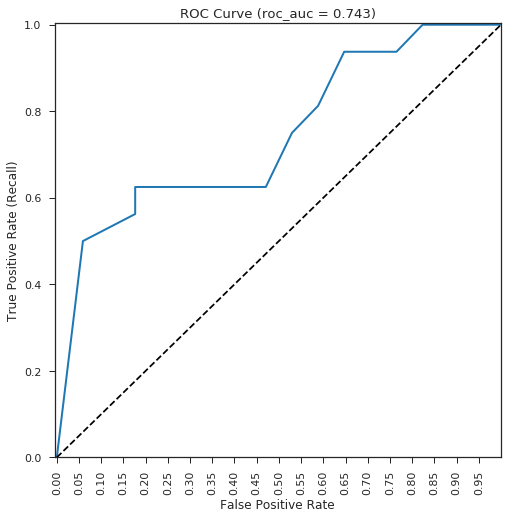

In [33]:
wrapper.roc_curve(X_test, y_test)

### logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression

wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=LogisticRegression(random_state=RANDOM_SEED),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.0s finished


In [17]:
wrapper.print_scores()

best score (roc_auc): 0.908

best params:
{'pca': None,
 'preprocessing__numerical__polyfeatures': None,
 'preprocessing__numerical__scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


### naive bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=GaussianNB(),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.0s finished


In [19]:
wrapper.print_scores()

best score (roc_auc): 0.898

best params:
{'pca': PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='full', tol=0.0, whiten=False),
 'preprocessing__numerical__polyfeatures': None,
 'preprocessing__numerical__scale': None,
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


### k-nearest neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=KNeighborsClassifier(),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.9s finished


In [21]:
wrapper.print_scores()

best score (roc_auc): 0.865

best params:
{'pca': None,
 'preprocessing__numerical__polyfeatures': PolynomialFeatures(degree=3, include_bias=True, interaction_only=False),
 'preprocessing__numerical__scale': None,
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


### gradient boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

model_param = {
    'learning_rate': 0.001,
    'max_depth': 1,
    'max_features': 0.75,
    'min_samples_leaf': 7,
    'min_samples_split': 16,
    'n_estimators': 100,
    'subsample': 0.3,
    'random_state': RANDOM_SEED
}

wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=GradientBoostingClassifier(**model_param),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    5.0s finished


In [13]:
wrapper.print_scores()

best score (roc_auc): 0.912

best params:
{'pca': PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='full', tol=0.0, whiten=False),
 'preprocessing__numerical__polyfeatures': None,
 'preprocessing__numerical__scale': None,
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


### XGBoost

https://jessesw.com/XG-Boost/

In [22]:
from xgboost import XGBClassifier
import warnings

model_param = {
    'learning_rate': 0.001,
    'max_depth': 1,
    'max_features': 0.75,
    'min_samples_leaf': 7,
    'min_samples_split': 16,
    'n_estimators': 100,
    'subsample': 0.3,
    'random_state': RANDOM_SEED
}

warnings.simplefilter('ignore')
wrapper = GridSearchWrapper(base_pipeline=pipeline_preprocessing,
                            model=XGBClassifier(**model_param),
                            param_grid=param_grid,
                            scoring=scoring)

wrapper.fit(X_train, y_train.ravel())
warnings.simplefilter('default')

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.6s finished


In [23]:
wrapper.print_scores()

best score (roc_auc): 0.902

best params:
{'pca': PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='full', tol=0.0, whiten=False),
 'preprocessing__numerical__polyfeatures': None,
 'preprocessing__numerical__scale': None,
 'preprocessing__numerical__selecthighsrm': FunctionTransformer(accept_sparse=False,
          func=<function get_high_srm_cols at 0x7f1709cb9488>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)}


/home/romain/.local/share/virtualenvs/fatigue-WgHAVgza/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.72      0.76      0.74        17
          1       0.73      0.69      0.71        16

avg / total       0.73      0.73      0.73        33



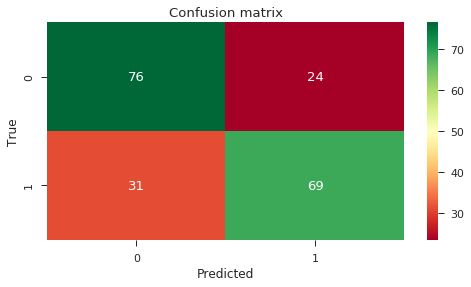

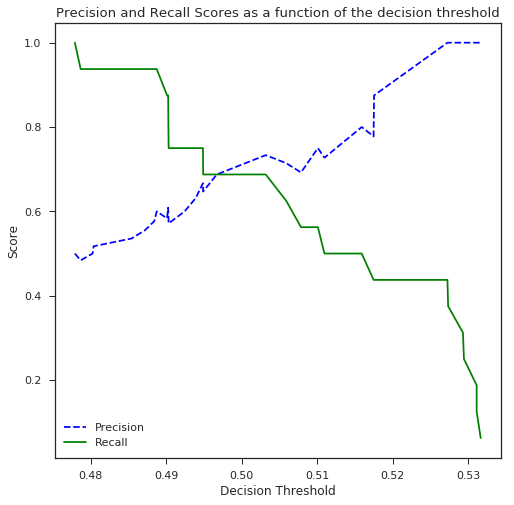

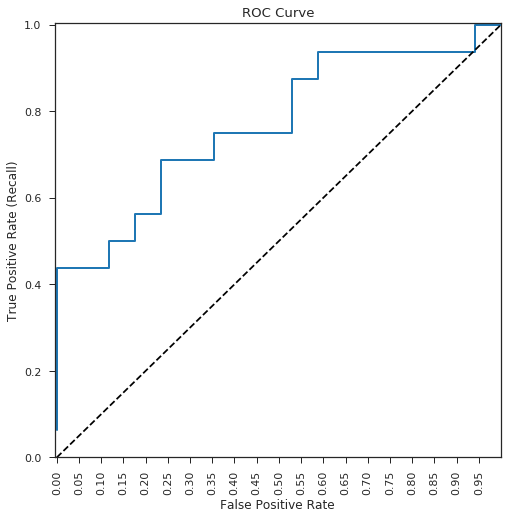

In [46]:
wrapper.evaluate(X_test, y_test)

---
KERAS

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [13]:
X_train.shape

(129, 26)

In [19]:
from keras.models import Sequential
from keras.layers import Dense

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=26, activation='relu'))
    model.add(Dense(26, activation='relu'))
    model.add(Dense(26, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=10,
                     verbose=1)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(NN, X, y, cv=kfold)

In [ ]:
NN.fit(X_train, y_train)